In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil

from utils import *
from datasets import *
from models import *
from profiler import WingbeatDatasetProfiler

Available workers: 16


# Cleaning Settings

In [3]:
maxpeaks = 15
minpeaks = 1
maxscore = 15
minscore = 2.5
minduration = 100
selection = f"peaks>={minpeaks} & peaks<={maxpeaks} & score>{minscore} & score<={maxscore} & duration>={minduration}"

# Dataset SD

In [8]:
dataset_sd = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/", bandpass_low=140., bandpass_high=1500., rpiformat=False, custom_label=[0])

Found 21129 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_sd/Melanogaster/, and 1 label(s): ['from_sd']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Dataset RPi

In [9]:
dataset_rpi = WingbeatDatasetProfiler(dsname="/home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/", bandpass_low=140., bandpass_high=1500., rpiformat=True, custom_label=[0])

Found 436 in dataset: /home/kalfasyan/data/wingbeats/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/, and 1 label(s): ['from_rpi']
Label(s) changed to [0]


  warnings.warn('nperseg = {0:d} is greater than input length '
  warnings.warn('nperseg = {0:d} is greater than input length '
  warnings.warn('nperseg = {0:d} is greater than input length '


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration..
Sum..
Max..
Bad chunk score
Filename..
Date..
Date string..
Datehour string..
Finished.


# Comparison

In [10]:
df_rpi = dataset_rpi.df.query(selection)
print('rpi')
print(df_rpi.shape)
df_sd = dataset_sd.df.query(selection)
print('sd')
print(df_sd.shape)
df_sd = df_sd.sample(df_rpi.shape[0])
print('downsampling')
print(df_sd.shape)

rpi
(346, 14)
sd
(12509, 14)
downsampling
(346, 14)


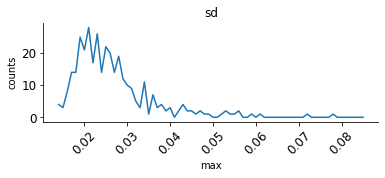

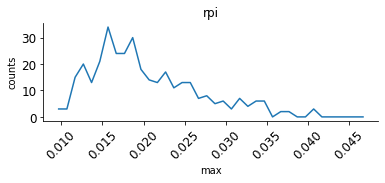

In [11]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'max', res=0.001)
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'max', res=0.001)

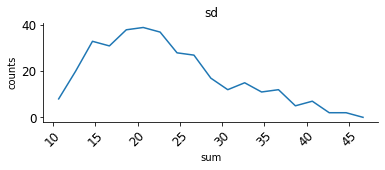

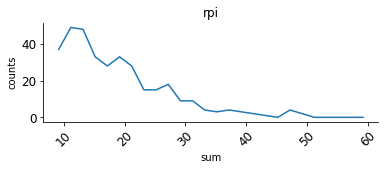

In [12]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'sum', res=2, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'sum', res=2)

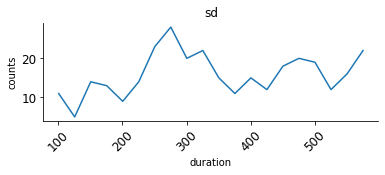

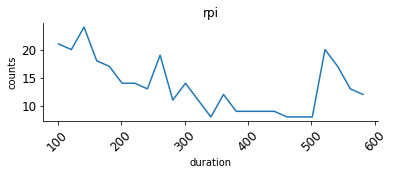

In [13]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'duration', res=25, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'duration', res=20)

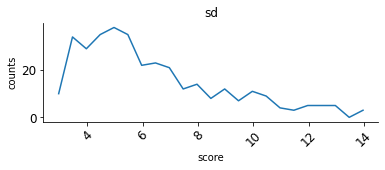

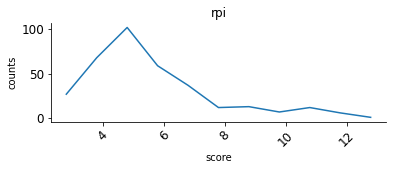

In [14]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'score', res=0.5, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'score', res=1)

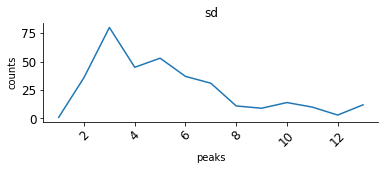

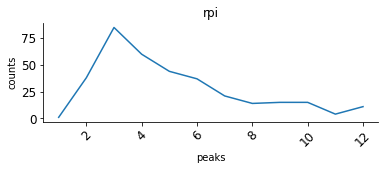

In [15]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'peaks', res=1, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'peaks', res=1)

# Bad Chunk Score

 25%|██▌       | 5/20 [00:00<00:00, 43.19it/s]

251 out of 346


100%|██████████| 20/20 [00:00<00:00, 55.21it/s]


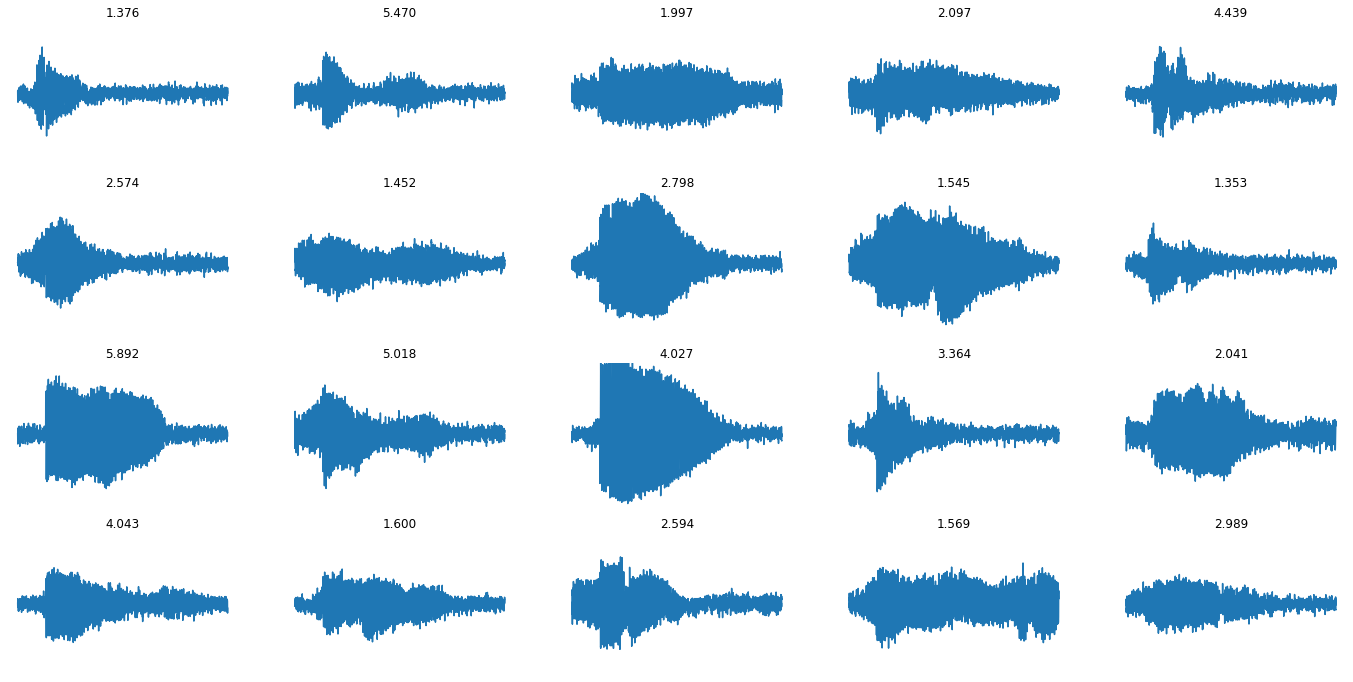

In [24]:
bcs = 1.3

df = df_rpi[df_rpi.badchunkscore>bcs]
print(f"{df.shape[0]} out of {df_rpi.shape[0]}")

plt.figure(figsize=(24,12))
for i in tqdm(range(20)):
    plt.subplot(4,5,i+1)
    plt.plot(open_wingbeat(df.x.iloc[i]).squeeze().numpy())
    plt.ylim(-.03,.03)
    plt.axis('off')
    plt.title(f"{df.badchunkscore.iloc[i]:.3f}")

In [25]:
df_rpi[df_rpi.badchunkscore>=.8].shape


(297, 14)

In [26]:
df_rpi.shape

(346, 14)

## How BCS was made

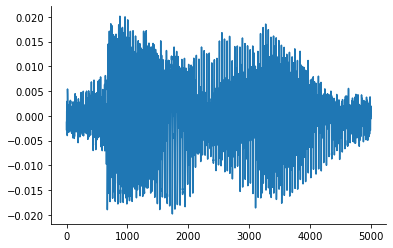

PartA score: 2.3780077212953112
PartB score: 6.082247307804468
PartB score - PartA score : 3.7042395865091566


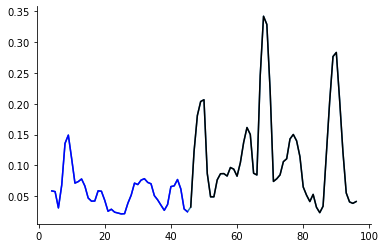

In [27]:
n = np.random.randint(0, len(df_rpi))

open_wingbeat(df_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_rpi.x.iloc[n]).squeeze().numpy()
sig = scale(sig)

part = sig[620:712+5]
part = pd.Series(part).rolling(5).std().abs()
part.plot()

partA = part.iloc[:46]
partB = part.iloc[46:]
# plt.figure()
partA.plot(color='b')
partB.plot(color='k')

scoreA = partA.sum()
scoreB = partB.sum()

score = scoreB - scoreA

print(f"PartA score: {scoreA}\nPartB score: {scoreB}")
print(f"PartB score - PartA score : {score}")

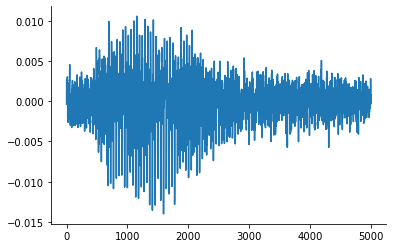

2.801695512967107

In [28]:
n = np.random.randint(0, len(df_rpi))
open_wingbeat(df_rpi.x.iloc[n], plot=True)
sig = open_wingbeat(df_rpi.x.iloc[n]).squeeze().numpy()

get_bad_first_chunk_score(sig)

# Using DrosophilaNet

In [ ]:
model = DrosophilaNetRAW(outputs=2, dropout_p=.2)

# criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular")
# early_stopping = EarlyStopping(patience=10, verbose=1)
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model = load_checkpoint("../data_created/model_time_best.pth.tar", model, optimizer)[0]
model.eval();

In [ ]:
preds = []
for n in tqdm(range(len(df_rpi))):
    sig = open_wingbeat(df_rpi.x.iloc[n])
    preds.append(int(model(sig.unsqueeze(0)).argmax()))

In [ ]:
df_rpi['preds'] = preds

In [ ]:
df_rpi.query("preds==0").badchunkscore.median()

In [ ]:
df_rpi.query("preds==1").badchunkscore.median()

In [ ]:
open_wingbeat(df_rpi.x.iloc[0])